In [1]:
import numpy as np
import pickle
import SimpleITK as sitk
import matplotlib.pyplot as plt

In [2]:
with open(r'/home/liusheng/worksapce2024/Projects/RadiSmart/jupyters/resource/post_data/4.rest_g.pickle', 'rb') as f2:
    ipt_data = pickle.load(f2)
ipt_data = ipt_data["Rest"]
print(ipt_data.keys(), ipt_data["Image"]["Meta"]["Shape"])
print(ipt_data["Image"]["Meta"]["PixelSize"])

dict_keys(['Image', 'ROIInfo', 'Limits']) {'X': 80, 'Y': 80, 'Z': 81}
{'X': 6.64, 'Y': 6.64, 'Z': 6.64}


In [4]:
# 载入数据
sitk_img = sitk.ReadImage('./data/000652515.nii.gz')
# z,x,y 81, 80, 80/ min value: 0
ori_img = sitk.GetArrayFromImage(sitk_img)
# 限制最大信号量
ori_img[ori_img > 50] = 50  
# {'X': 6.64, 'Y': 6.64, 'Z': 6.64} 
pixel_size = [6.64, 6.64, 6.64]
img_size = [81, 80, 80]
# 存在心脏的起止切片大致范围
approx_start_z_ind, approx_end_z_ind = int(73.084 / pixel_size[0]), int(305.624 / pixel_size[0]) 

print(approx_start_z_ind, approx_end_z_ind)

11 46


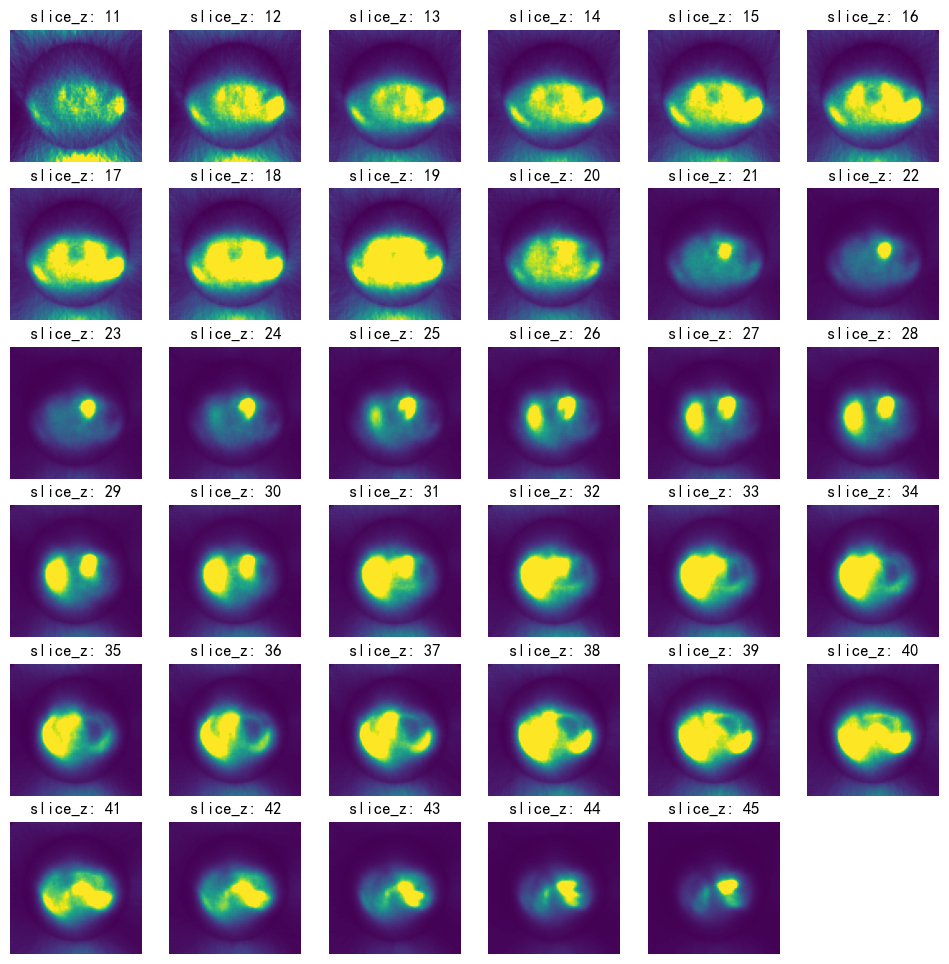

In [30]:
plt.figure(figsize=(12,12))
for sub_id, slice_z in enumerate(range(approx_start_z_ind, approx_end_z_ind), start=1):
    ax = plt.subplot(6,6,sub_id)
    plt.imshow(ori_img[slice_z], vmax = np.max(ori_img[slice_z])*0.5)
    ax.set_axis_off()
    ax.set_title(f'slice_z: {slice_z}')

In [6]:
# 确定心脏范围
# 可以矢量化改进提速

def extract_feature(ori_img, approx_indices):
    img_size = ori_img.shape
    approx_start_z_ind, approx_end_z_ind = approx_indices  # 存在心脏的大约起止切片 z 轴
    slice_nb = approx_end_z_ind - approx_start_z_ind + 1
    slice_px_nb = np.zeros(slice_nb)  # 大于阈值的像素数量
    slice_px_nb_ns = np.zeros(slice_nb)  # 递增方向像素数量和
    slice_px_nb_fs = np.zeros(slice_nb)  # 递减方向像素数量和
    slice_max_coor = np.zeros((slice_nb, 2))  # 最大像素值对应的坐标
    slice_max_dis = np.zeros(slice_nb)  # 最大像素值对应的坐标与图像左上角距离
    slice_neibour_dis = np.zeros(slice_nb)  # 相邻切片最大像素的距离差值

    # 切片特征提取
    for z_ind in range(approx_start_z_ind, approx_end_z_ind + 1):
        image2d = ori_img[z_ind]
        max_px_val = image2d.max()
        threshold = max_px_val * 0.5
        idx = np.where(image2d > threshold)
        slice_px_nb[z_ind - approx_start_z_ind] = np.size(idx[0])
        idx = np.where(image2d >= max_px_val * 0.95)
        min_dis, yc, xc = 1000, 0, 0
        for i in range(np.size(idx[0])):
            yc1, xc1 = idx[0][i], idx[1][i]
            dis = np.sqrt(yc1 ** 2 + (img_size[2] - xc1) ** 2)
            if min_dis > dis:
                min_dis = dis
                yc, xc = yc1, xc1
        slice_max_coor[z_ind - approx_start_z_ind, :] = yc, xc
        slice_max_dis[z_ind - approx_start_z_ind] = np.sqrt(yc ** 2 + (img_size[2] - xc) ** 2)

    for i in range(slice_nb):
        idx = np.min([i + 3, slice_nb])
        slice_px_nb_ns[i] = np.sum(slice_px_nb[i: idx]) / (idx - i)
        if i > 0:
            slice_neibour_dis[i] = np.sqrt(
                (slice_max_coor[i, 0] - slice_max_coor[i - 1, 0]) ** 2 + (slice_max_coor[i, 1] - slice_max_coor[i - 1, 1]) ** 2)

    for i in range(slice_nb):
        idx = np.max([i - 3, 0])
        if i > 0:
            slice_px_nb_fs[i] = np.sum(slice_px_nb[idx: i]) / (i - idx)
        else:
            slice_px_nb_fs[i] = slice_px_nb[i]

    return slice_neibour_dis, slice_px_nb_ns, slice_px_nb_fs, slice_px_nb, slice_max_dis, slice_max_coor


In [7]:
tmp_res = extract_feature(ori_img, [approx_start_z_ind, approx_end_z_ind])
slice_neibour_dis, slice_px_nb_ns, slice_px_nb_fs, slice_px_nb, slice_max_dis, slice_max_coor= tmp_res
# slice_px_nb = np.zeros(slice_nb)  # 大于阈值的像素数量
# slice_px_nb_ns = np.zeros(slice_nb)  # 递增方向像素数量和
# slice_px_nb_fs = np.zeros(slice_nb)  # 递减方向像素数量和
# slice_max_coor = np.zeros((slice_nb, 2))  # 最大像素值对应的坐标
# slice_max_dis = np.zeros(slice_nb)  # 最大像素值对应的坐标与图像左上角距离
# slice_neibour_dis = np.zeros(slice_nb)  # 相邻切片最大像素的距离差值

In [15]:
# slice_neibour_dis

In [16]:
# slice_px_nb_ns

In [17]:
# slice_px_nb_fs

In [18]:
# slice_px_nb

In [19]:
# slice_max_dis

In [20]:
# slice_max_coor

In [27]:
def locate_cardiac_begin_slice(ori_img, slice_neibour_dis, slice_px_nb_ns, slice_px_nb_fs, 
                               slice_px_nb, slice_max_dis, approx_start_z_ind, slc_con, pixel_size):
    # fuc 定位心脏起始切片
    # ipt 特征集
    # opt 心脏起始切片索引

    # 根据像素数量梯度切片分类
    slc_nb = np.size(slice_neibour_dis)
    min_grd_val = 10  # 最小梯度
    # 可能的心脏切片起始索引
    slc_sor_idx = np.zeros(20, np.int16) 
    sor_nb = 1  # 切片类别数量
    for i in range(slc_nb):
        if slice_neibour_dis[i] >= min_grd_val:
            slc_sor_idx[sor_nb] = i
            sor_nb += 1

    # 找出合法像素数量的切片
    max_px_nb = 150
    min_px_nb = 200
    slc_leg = np.zeros(slc_nb)
    slc_leg[slice_px_nb <= max_px_nb] = 1
    car_bidx = 0

    for slc_idx in range(slc_nb):
        if slc_leg[slc_idx]:
            if slice_px_nb_ns[slc_idx] <= max_px_nb:
                if slice_px_nb_fs[slc_idx] >= min_px_nb:
                    if slice_px_nb[slc_idx] <= 15:  # 不符合最少像素数量，重置计数
                        slice_px_nb[slc_idx] = min_px_nb
                        for i in range(slc_nb):
                            idx = np.min([i + 3, slc_nb])
                            slice_px_nb_ns[i] = np.sum(slice_px_nb[i: idx]) / (idx - i)
                        for i in range(slc_nb):
                            idx = np.max([i - 3, 0])
                            if i > 0:
                                slice_px_nb_fs[i] = np.sum(slice_px_nb[idx: i]) / (i - idx)
                            else:
                                slice_px_nb_fs[i] = slice_px_nb[i]
                    else:
                        max_dis = 58
                        if slice_max_dis[slc_idx] > max_dis:  # 不符合最远距离，重新查找

                            # 判断不同类别切片起始层是否满足数量要求
                            min_slc_num = 5  # 最小切片数量
                            slc_leg = np.zeros(sor_nb)
                            for i in range(sor_nb):
                                slc_idx = slc_sor_idx[i]
                                if i < sor_nb - 1:
                                    if slc_sor_idx[i + 1] - slc_idx >= min_slc_num and slice_max_dis[slc_idx] <= max_dis:
                                        slc_leg[i] = 1
                                else:
                                    if slc_nb - slc_idx + 1 >= min_slc_num and slice_max_dis[slc_idx] <= max_dis:
                                        slc_leg[i] = 1

                            # 找出最可能的心脏起始层切片
                            min_dis = 1000
                            for i in range(sor_nb):
                                slc_idx = slc_sor_idx[i]
                                if slc_leg[i] == 1:
                                    if i < sor_nb - 1:
                                        dis = (np.sum(slice_max_dis[slc_idx: slc_sor_idx[i + 1]])
                                               / (slc_sor_idx[i + 1] - slc_idx))
                                    else:
                                        dis = np.sum(slice_max_dis[slc_idx:]) / (slc_nb - slc_idx + 1)
                                    if min_dis > dis:
                                        min_dis = dis
                                        car_bidx = slc_idx
                        else:
                            car_bidx = slc_idx
                        break

    # 提取心脏区域
    zs, ys, xs = ori_img.shape
    yc, xc, hfl, hfw = int(slc_con[car_bidx, 0]), int(slc_con[car_bidx, 1]), 12, 12
    car_bidx = car_bidx + approx_start_z_ind
    car_eidx = min(car_bidx + int(np.ceil(100 / pixel_size[0])), zs - 1)
    car_slc_nb = car_eidx - car_bidx
    car_eidx0, car_bidx0 = car_eidx, car_bidx
    car_bidx -= int((hfl * 2 - car_slc_nb) / 2)
    car_eidx += int((hfl * 2 - car_slc_nb) / 2)
    car_slc_nb = car_eidx - car_bidx
    if car_slc_nb < hfl * 2:
        car_eidx += 1
    car_img = np.zeros((car_slc_nb, hfl * 2, hfw * 2), dtype=np.float32)
    for i in range(car_bidx, car_eidx):
        print(i, yc, xc)
        car_img[i - car_bidx, :, :] = ori_img[i, yc - hfl: yc + hfl, xc - hfw: xc + hfw]

    spr_dict = {"X": xc, "Y": yc, "Z": (car_bidx + car_eidx) / 2, "R": hfl}  # 心脏球形范围
    # car_ofs = xc - hfw, yc - hfl, car_bidx
    bg_idx = 0 + car_bidx0 - car_bidx
    ed_idx = car_slc_nb - (car_eidx - car_eidx0)

    car_ofs = [-(xs / 2 - spr_dict['X']) * pixel_size[2], 
               -(ys / 2 - spr_dict['Y']) * pixel_size[1], 
               -(zs / 2 - spr_dict['Z']) * pixel_size[0]]

    return car_img, car_bidx, spr_dict, car_ofs, [bg_idx, ed_idx]

In [28]:
# 定位心脏起始层
car_img, car_bidx, spr_dict, car_ofs, car_idx = locate_cardiac_begin_slice(ori_img, slice_neibour_dis, slice_px_nb_ns,
                                                                            slice_px_nb_fs, slice_px_nb, slice_max_dis,
                                                                            approx_end_z_ind, slice_max_coor, pixel_size)

51 38 47
52 38 47
53 38 47
54 38 47
55 38 47
56 38 47
57 38 47
58 38 47
59 38 47
60 38 47
61 38 47
62 38 47
63 38 47
64 38 47
65 38 47
66 38 47
67 38 47
68 38 47
69 38 47
70 38 47
71 38 47
72 38 47
73 38 47
74 38 47


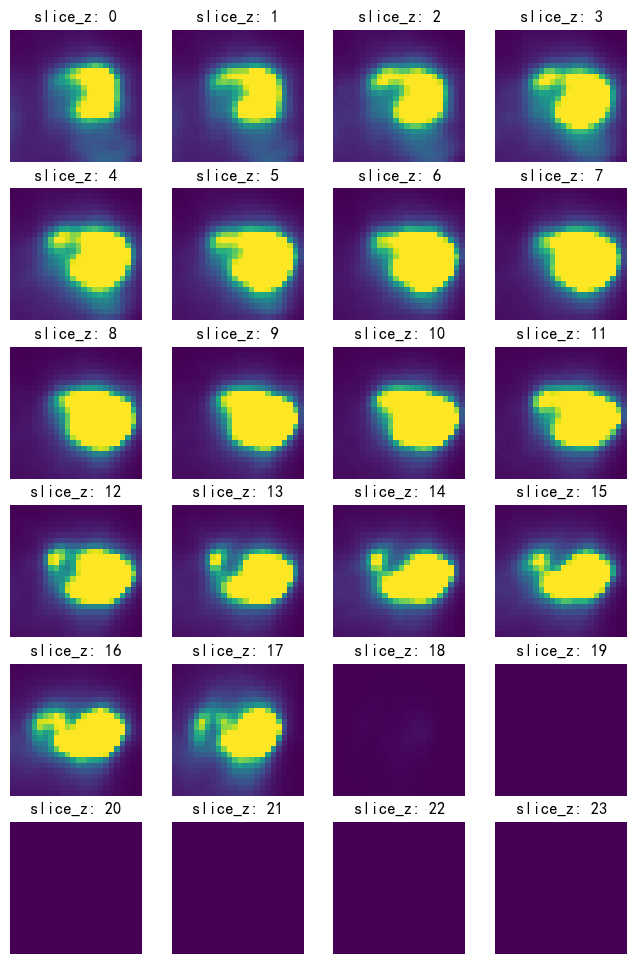

In [33]:
zs = car_img.shape[0]

plt.figure(figsize=(8,12))
for sub_id, slice_z in enumerate(range(zs), start=1):
    ax = plt.subplot(6,4,sub_id)
    plt.imshow(car_img[slice_z], vmax = np.max(car_img))
    ax.set_axis_off()
    
    ax.set_title(f'slice_z: {slice_z}')

In [ ]:
# 确定左心室轴心
la_agl_xy, la_agl_z, axhl_dict, axvl_dict = cadc_reorient.determinate_cardiac_axes(car_img, car_idx)